# Load and Preprocess Data

This notebooks performs the following steps: 
1) Load raw data 
2) Clean and preprocess data into input features and targets 
3) Save data to be used later 

In [1]:
# Train an XGBoost Model to predict Tackle Probability
import torch 
import numpy as np
import pandas as pd
import random
import os
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from data_preprocessing import aggregate_data, annotate_missed_tackle_frames, annotate_tackle_frames, build_training_tackle_sequences
from data_cleaning import clean_data, optimize_memory_usage
from constants import TACKLENET_FEATURE_DICT

VERBOSE = False      # for debugging
root_dir = os.getcwd()

# set manual custom seed for reproducibility
def set_random_seed(value): 
    g = torch.manual_seed(value)   
    np.random.seed(value)
    random.seed(value)
    torch.backends.cudnn.deterministic=True
    return g

%load_ext autoreload
%autoreload 2

In [2]:
# import data and create aggregate dataframe
load_saved_data = False             # Set to true if you'd like to load pre-saved tackle sequences and tracking data from the save/ dir

if not load_saved_data: 
    plays_fname = os.path.join(root_dir, "data/plays.csv")
    players_fname = os.path.join(root_dir, "data/players.csv")
    tackles_fname = os.path.join(root_dir, "data/tackles.csv")
    tracking_fname_list_train = [os.path.join(root_dir, f"data/tracking_week_{i}.csv") for i in range(1,9)]
    tracking_fname_list_test = [os.path.join(root_dir, "data/tracking_week_9.csv")]
    
    # variables to store train vs. test data for later 
    tackle_sequences_train = []
    tackle_sequence_test = []
    df_tracking_train = []
    df_tracking_test = []
    df_tackles_train = []
    df_tackles_test = []
    means = None
    stds = None
    unnorm_tensor_stack_train = None
    norm_tensor_stack_train = None
    unnorm_tensor_stack_test = None
    norm_tensor_stack_test = None

    for split in ["train", "test"]:
        print(f"===================== Processing {split} data... =====================")
        if split == "train":
            tracking_fname_list = tracking_fname_list_train
        elif split == "test":
            tracking_fname_list = tracking_fname_list_test

        # Aggregate data from the plays.csv, players.csv, tackles.csv, and any tracking data into one aggregate dataframe.
        df = aggregate_data(plays_fname, tackles_fname, players_fname, tracking_fname_list)

        # Preprocess and clean the data
        df_clean = clean_data(df)

        # optimize memory usage of dataframe
        df_opt = optimize_memory_usage(df_clean)

        # Annotate the frameId of both made tackles and missed tackles.
        # Note that currently, out-of-bounds tackles are not included, nor are assisted tackles (2 assists, 0 tackles)
        df_tackles = pd.read_csv(tackles_fname)
        df_tackles, tackle_ct = annotate_tackle_frames(df_opt, df_tackles)
        df_tackles, missed_tackle_ct = annotate_missed_tackle_frames(df_opt, df_tackles)
        
        print("INFO: CREATING TACKLE SEQUENCES FOR TRAINING...")
        # create TackleSequence objects 
        tackle_sequences = build_training_tackle_sequences(df_opt, 
                                                           df_tackles, 
                                                           offset_frames = 10, 
                                                           n_sequences = None, 
                                                           sequence_len = 1, 
                                                           dt = 1, 
                                                           verbose=VERBOSE,
                                                           )
        
        # split specific operations
        reverse_feature_dict = {value: key for key, value in TACKLENET_FEATURE_DICT.items()}
        if split == "train": 
            # # standardize the tackle_sequences
            # unnorm_tensor_stack_train, norm_tensor_stack_train, (means, stds) = standardize_tackle_sequences(tackle_sequences)
            # print("STANDARDIZATION RESULTS:")
            # for i in range(len(means)): 
            #     print(f"{reverse_feature_dict[i]} | mean: {means[i]} | std: {stds[i]}")
            
            # store variables to use later
            tackle_sequences_train = tackle_sequences
            df_tracking_train = df_opt
            df_tackles_train = df_tackles
        elif split == "test": 
            # # standardize the tackle_sequences using means/stds from training data
            # unnorm_tensor_stack_test, norm_tensor_stack_test, _ = standardize_tackle_sequences(tackle_sequences, means, stds)
            
            # store variables to use later
            tackle_sequences_test = tackle_sequences
            df_tracking_test = df_opt
            df_tackles_test = df_tackles
            
        # report data statistics
        groupby = df_opt.groupby(["gameId", "playId"])
        print(f"===================== {split} DATA STATISTICS =====================")
        print(f"INFO: There are {len(groupby)} unique plays in the {split} data")
        print(f"INFO: Within these plays there are {tackle_ct} tackles and {missed_tackle_ct} missed tackles (including plays with penalties)")
        print(f"INFO: After filtering out plays with penalties, mislabeled data, there were {len([ts for ts in tackle_sequences if ts.target == 1])} made and {len([ts for ts in tackle_sequences if ts.target == 0])} missed tackle sequences created in the {split} split.")

    # save data 
    print("INFO: SAVING TACKLE SEQUENCES...")
    current_datetime = datetime.now().strftime("%m%d%Y-%H%M")
    with open(os.path.join(root_dir, f"save/tackle_sequences_{current_datetime}.pkl"), "wb") as f: 
        ts_lists = {"train": tackle_sequences_train, "test": tackle_sequences_test}
        pickle.dump(ts_lists, f) 
    with open(os.path.join(root_dir, f"save/test_tracking_data_{current_datetime}.pkl"), "wb") as f: 
        pickle.dump(df_tracking_test, f)
    with open(os.path.join(root_dir, f"save/train_tracking_data_{current_datetime}.pkl"), "wb") as f: 
        pickle.dump(df_tracking_train, f)

else: 
    # load tackle sequences and tracking data from save/ dir
    print("INFO: LOADING TACKLE SEQUENCES")
    ts_lists = pickle.load(open(os.path.join(root_dir, "save/tackle_sequences_12262023-1754.pkl"), "rb"))
    df_tracking_test = pickle.load(open(os.path.join(root_dir, "save/test_tracking_data_12262023-1754.pkl"), "rb"))
    df_tracking_train = pickle.load(open(os.path.join(root_dir, "save/train_tracking_data_12262023-1754.pkl"), "rb"))
    tackle_sequences_train = ts_lists["train"]
    tackle_sequences_test = ts_lists["test"]

print("INFO: ... Done")

===================== Processing train data... =====================
INFO: Aggregating data from play data, tracking data, tackles data, and players data into a master dataframe...
INFO: Transforming orientation and direction angles so that 0° points from left to right, and increasing angle goes counterclockwise...
INFO: Flipping plays so that they all run from left to right...
INFO: Labeling plays as runs or passes
INFO: Removing play with penalties...
INFO: 520300 rows removed
INFO: Converting teams from str to numeric...
INFO: Memory usage reduced from 16063813005 to 14294543283
INFO: Removing inactive frames...
INFO: 2100934 rows removed
INFO: Removing bad data...
INFO: 0 rows removed
INFO: Removing unused columns from dataframe...
INFO: 46 columns removed
INFO: Converting geometry variables from floats to int...
INFO: Memory usage reduced from 1170616168 to 884917216
INFO: Downcasting integers and floats...
INFO: Memory usage reduced from 884917216 to 591282182
INFO: 17426 tacklin

annotate_tackle_frames:   0%|          | 0/11974 [00:00<?, ?it/s]

annotate_missed_tackle_frames:   0%|          | 0/11974 [00:00<?, ?it/s]

INFO: CREATING TACKLE SEQUENCES FOR TRAINING...


build_training_tackle_sequences:   0%|          | 0/11974 [00:00<?, ?it/s]

INFO: 2391 tackling events skipped due to missing tracking data, missing annotation data, or being too short
INFO: 9583 tackle sequences created
===================== train DATA STATISTICS =====================
INFO: There are 10749 unique plays in the train data
INFO: Within these plays there are 9999 tackles and 1785 missed tackles (including plays with penalties)
INFO: After filtering out plays with penalties, mislabeled data, there were 8000 made and 1583 missed tackle sequences created in the train split.
===================== Processing test data... =====================
INFO: Aggregating data from play data, tracking data, tackles data, and players data into a master dataframe...
INFO: Transforming orientation and direction angles so that 0° points from left to right, and increasing angle goes counterclockwise...
INFO: Flipping plays so that they all run from left to right...
INFO: Labeling plays as runs or passes
INFO: Removing play with penalties...
INFO: 46552 rows removed
IN

annotate_tackle_frames:   0%|          | 0/11974 [00:00<?, ?it/s]

annotate_missed_tackle_frames:   0%|          | 0/11974 [00:00<?, ?it/s]

INFO: CREATING TACKLE SEQUENCES FOR TRAINING...


build_training_tackle_sequences:   0%|          | 0/11974 [00:00<?, ?it/s]

INFO: 10958 tackling events skipped due to missing tracking data, missing annotation data, or being too short
INFO: 1016 tackle sequences created
===================== test DATA STATISTICS =====================
INFO: There are 1126 unique plays in the test data
INFO: Within these plays there are 1053 tackles and 204 missed tackles (including plays with penalties)
INFO: After filtering out plays with penalties, mislabeled data, there were 836 made and 180 missed tackle sequences created in the test split.
INFO: SAVING TACKLE SEQUENCES...
INFO: ... Done


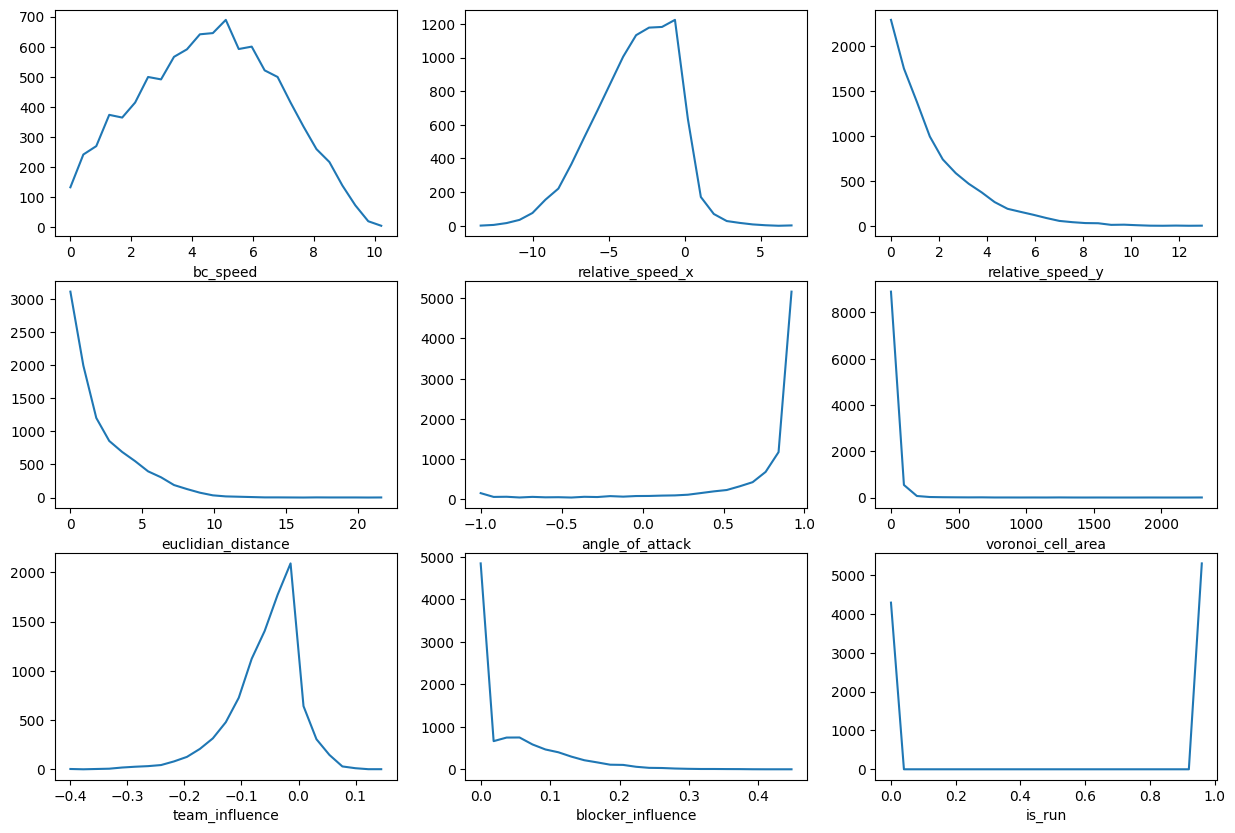

In [39]:
# Visualize the histogram of different features
num_features = 9
tensor_stack = torch.stack([ts.input_tensor for ts in tackle_sequences_train]).view(-1, num_features)
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 10)
reverse_feature_dict = {value: key for key, value in TACKLENET_FEATURE_DICT.items()}
for i in range(tensor_stack.shape[1]): 
    row = i // 3
    col = i % 3
    counts, bin_edges = np.histogram(tensor_stack[:,i], bins=25)
    axs[row][col].plot(bin_edges[:-1], counts)
    axs[row][col].set_xlabel(f"{reverse_feature_dict[i]}")
plt.show()